In [1]:
from astropy.io import fits
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os.path
from astropy.visualization import make_lupton_rgb
from reproject import reproject_interp
import pyyolo
import sys
from PIL import Image, ImageEnhance
import matplotlib.patches as patches
import time

# This example shows the filter_rgb function, which allows to transform arrays obtained from three .fits filters into a PIL Image module.
# You can visualize up to four filters for comparison purposes
# This process is quite important since the darknet trainer works with .jpg images and not .fits
# Finally, detections with YOLO are ran for every image. The weights for this example are the results of a traning with images only with the lupton filter.

fnamer='example4/1458_301_4_387.r.fits' 
fnameg='example4/1458_301_4_387.g.fits'
fnamei='example4/1458_301_4_387.i.fits' #These are the names of the .fits for the respective filters

thresh = 0.02 #detection probability threshold

In [2]:
# r_band,g_band and b_band are NxNx1 numpy arrays with the data from the .fits
# stretch_type is the function you want to use for the stretch. You can choose between log, sqrt, lupton, sinh, power and exp
# if you want to use a power function, write it as 'power_n', where n is the power you want to use (non-integers can be used)
# factor increases the brightness of the image by multiplying the output matrix for said factor (before converting to image)
# centered uses the mean of the image matrix as the zero point (below zero the image sets the value to black). Will be ignored if zero has an input
# normalized, if true, scales the matrix so the data is in the [0,1] range before applying the stretch. Will be ignored when using a lupton stretch
# min_zero substracts the minimum value of the input matrix so every value is greater or equal than zero
# zero sets the percentile of the pixels which are set to black (zero=1 will graph the lower 1% of the pixels to black)
# trunc sets the percentile of the pixels where high values are truncated. (trunc=50 makes the higher 50% of the pixels to the 50 percentile value)


def filter_rgb(r_band,g_band,b_band,stretch_type='log',factor=1,centered=False,normalized=False,min_zero=False,zero=-1,trunc=0):
    
  
    if stretch_type == 'lupton':
        stretch = factor
        minimum = zero
        
        if factor == 1:
            stretch = 5
            
        if minimum <0:
            minimum = 0
        image = make_lupton_rgb(r_band , g_band , b_band , stretch = stretch , minimum = minimum)
        ret = Image.fromarray(image)      
        return ret 
    
    

    if min_zero or stretch_type == 'log' or stretch_type == 'sqrt':


        r = r_band[:] - np.nanmin([r_band,g_band,b_band])
        g = g_band[:] - np.nanmin([r_band,g_band,b_band])
        b = b_band[:] - np.nanmin([r_band,g_band,b_band])

    else:
        r = r_band[:]
        g = g_band[:]
        b = b_band[:]        
    
    if trunc!=0:
        
        m=np.nanstd([r,g,b])
        n=np.nanmedian([r,g,b])
        cut= n + trunc * m        
        r = np.minimum(r,cut)
        g = np.minimum(g,cut)
        b = np.minimum(b,cut)

    rgb_min = np.nanmin([r,g,b])
    rgb_max = np.nanmax([r,g,b])
    norm_max =  float(rgb_max) - rgb_min

    if normalized:
        
        r = r/norm_max
        g = g/norm_max
        b = b/norm_max
    
    if stretch_type == 'log':
        
        ir = np.log(r+0.000001)
        ig = np.log(g+0.000001)
        ib = np.log(b+0.000001)
        
    elif stretch_type == 'sqrt':
        
        ir = np.sqrt(r)
        ig = np.sqrt(g)
        ib = np.sqrt(b*1.3) 
        
    elif stretch_type == 'sinh':
        
        ir = np.sinh(r)
        ig = np.sinh(g)
        ib = np.sinh(b)
        

    elif stretch_type[0:5] == 'power':
        power = float(stretch_type.split('_')[1])
        ir = np.power(r,power)
        ig = np.power(g,power)
        ib = np.power(b,power)
        

    elif stretch_type == 'exp':
        
        ir = np.exp(r)
        ig = np.exp(g)
        ib = np.exp(b)
        
    else: 
        
        return None
        
    if zero > 0:
        
        z = vmin = np.nanpercentile([ir,ig,ib],zero)
        ir -= z
        ig -= z
        ib -= z
        
    else:

        if centered and np.nanmax([ir,ig,ib])!=float('inf') and np.nanmin([ir,ig,ib])!=-float("inf"):
            
            mean = np.nanmean([ir,ig,ib])
            ir = ir - mean
            ig = ig - mean
            ib = ib - mean

        else:
            minim = np.nanmin([ir,ig,ib])
            ir = ir - minim
            ig = ig - minim
            ib = ib - minim
            
    ir*=factor
    ig*=factor
    ib*=factor
    im_r=Image.fromarray(ir).convert('L')
    im_g=Image.fromarray(ig).convert('L')
    im_b=Image.fromarray(ib).convert('L')
    image = Image.merge("RGB", (im_r , im_g , im_b))

    return image

In [3]:
imrr=fits.open(fnamer)
imgg=fits.open(fnameg)
imii=fits.open(fnamei)
imr=imrr[0]
img=imgg[0]
imi=imii[0]
ir = imr.data
w=ir.shape[1]
h=ir.shape[0]
ig, footprint1 = reproject_interp(img, imr.header)
ii, footprint2 = reproject_interp(imi, imr.header)

hier_thresh = 0.5
darknet_path = './data/darknet' #darknet path
datacfg = '../sdss.data' #relative to darknet path
cfgfile = '../sdss.cfg' #relative to darknet path
weightfile = '/home/cristian/astroCV/galaxy_detection/weights/galaxy_sdss_hic.weights' #weights dowloaded from github

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


/home/cristian/.local/lib/python2.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: overflow encountered in sinh
/home/cristian/.local/lib/python2.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: overflow encountered in multiply


Initialization time = 9.429 seconds
Load from file + Image processing time = 0.359 seconds
{'right': 26, 'bottom': 169, 'top': 118, 'class': 'Elliptical ', 'prob': 0.04404723271727562, 'left': 0}
{'right': 715, 'bottom': 190, 'top': 142, 'class': 'Elliptical ', 'prob': 0.10558287054300308, 'left': 670}
{'right': 873, 'bottom': 467, 'top': 416, 'class': 'Spiral', 'prob': 0.2777872681617737, 'left': 817}
{'right': 1084, 'bottom': 806, 'top': 779, 'class': 'Elliptical ', 'prob': 0.03051505796611309, 'left': 1057}


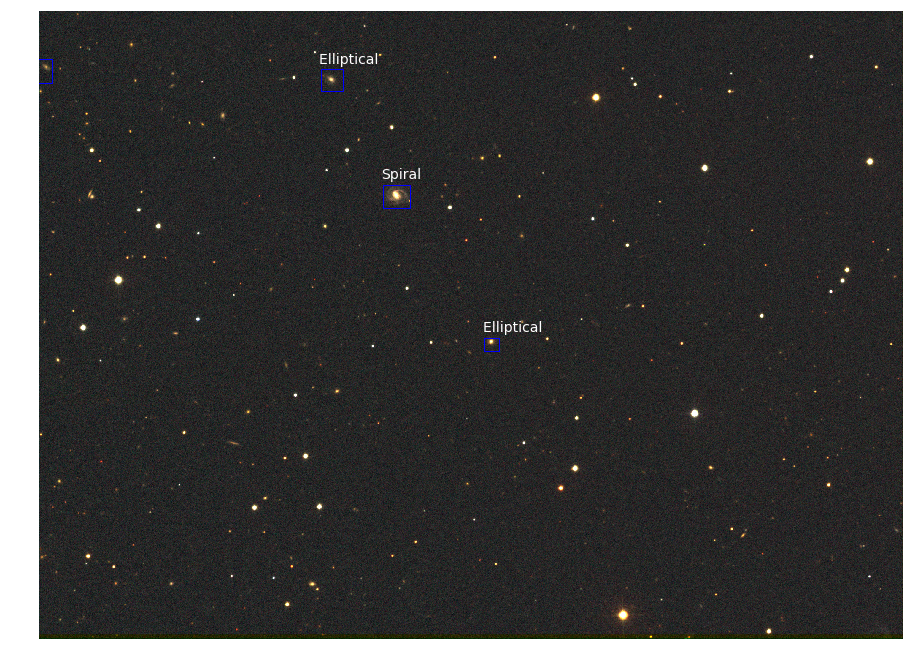

In [4]:
image =  filter_rgb(ii,ir,ig,stretch_type='sinh',factor=350,normalized=False,zero=0.03)

filename = 'image.jpg'

image.save(filename,'jpeg',quality=97)
t1=time.time()
pyyolo.init(darknet_path, datacfg, cfgfile, weightfile) #init and load network
print('Initialization time = %5.3f seconds'%(time.time()-t1))
t1=time.time() #actually loading the image take most of the time
outputs = pyyolo.test(filename, thresh, hier_thresh, 0,0) #load image and process
print('Load from file + Image processing time = %5.3f seconds'%(time.time()-t1))
for output in outputs:
        print(output)    
pyyolo.cleanup()

#plot image and detections
img = Image.open(filename)
fig,ax = plt.subplots(figsize=(12,9))
plt.axis('off')
plt.tight_layout(pad=0)
plt.imshow(img)
ax.set_aspect('equal')
for output in outputs:
        r=output['right']
        l=output['left']
        t=output['top']
        b=output['bottom']
        rect = patches.Rectangle((l-4,t-3),r-l+8,b-t+4,linewidth=1,edgecolor='b',facecolor='none')      
        ax.add_patch(rect)
        ax.annotate(output['class'],(l-7,t-18),color='w',fontsize=14)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0) 
plt.show()
plt.close()
os.remove(filename)


Initialization time = 3.516 seconds
Load from file + Image processing time = 0.339 seconds
{'right': 1989, 'bottom': 377, 'top': 341, 'class': 'Elliptical ', 'prob': 0.027352863922715187, 'left': 1959}
{'right': 891, 'bottom': 480, 'top': 403, 'class': 'Spiral', 'prob': 0.08558642119169235, 'left': 806}


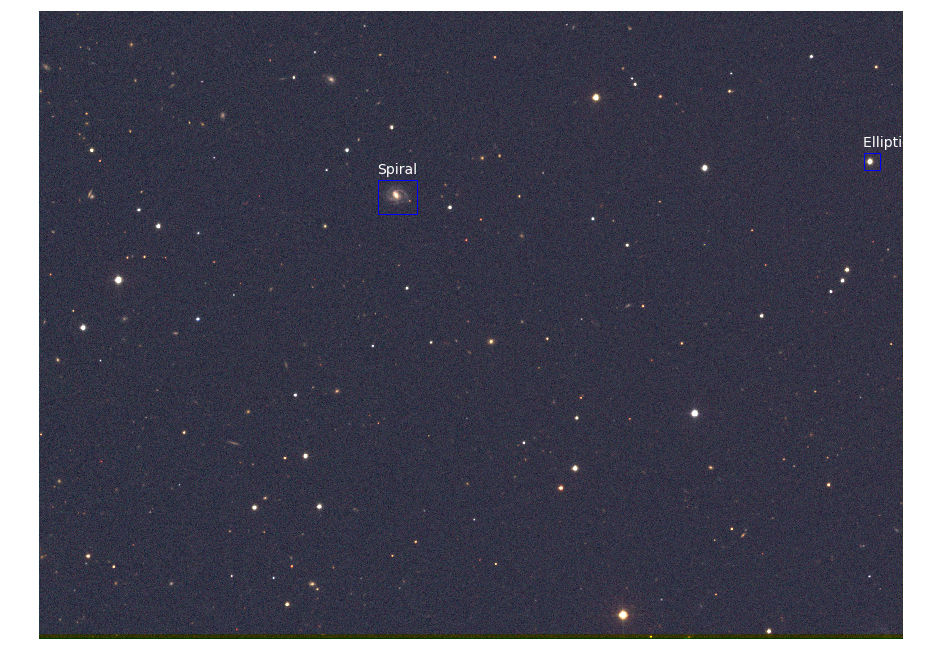

In [5]:
image =  filter_rgb(ii,ir,ig,stretch_type='sqrt',factor=500,normalized=True,trunc=6,zero=0.01)



image.save(filename,'jpeg',quality=97)

t1=time.time()
pyyolo.init(darknet_path, datacfg, cfgfile, weightfile) #init and load network
print('Initialization time = %5.3f seconds'%(time.time()-t1))
t1=time.time() #actually loading the image take most of the time
outputs = pyyolo.test(filename, thresh, hier_thresh, 0,0) #load image and process
print('Load from file + Image processing time = %5.3f seconds'%(time.time()-t1))
for output in outputs:
        print(output)    
pyyolo.cleanup()

#plot image and detections
img = Image.open(filename)
fig,ax = plt.subplots(figsize=(12,9))
plt.axis('off')
plt.tight_layout(pad=0)
plt.imshow(img)
ax.set_aspect('equal')
for output in outputs:
        r=output['right']
        l=output['left']
        t=output['top']
        b=output['bottom']
        rect = patches.Rectangle((l-4,t-3),r-l+8,b-t+4,linewidth=1,edgecolor='b',facecolor='none')      
        ax.add_patch(rect)
        ax.annotate(output['class'],(l-7,t-18),color='w',fontsize=14)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0) 
plt.show()
plt.close()
os.remove(filename)

/usr/local/lib/python2.7/dist-packages/astropy/visualization/lupton_rgb.py:158: RuntimeWarning: invalid value encountered in less
  c[c < 0] = 0                # individual bands can still be < 0, even if fac isn't


Initialization time = 3.508 seconds
Load from file + Image processing time = 0.323 seconds
{'right': 711, 'bottom': 179, 'top': 146, 'class': 'Elliptical ', 'prob': 0.19918730854988098, 'left': 674}
{'right': 450, 'bottom': 262, 'top': 237, 'class': 'Elliptical ', 'prob': 0.04085708409547806, 'left': 424}
{'right': 1586, 'bottom': 388, 'top': 369, 'class': 'Elliptical ', 'prob': 0.4733196198940277, 'left': 1566}
{'right': 1978, 'bottom': 368, 'top': 349, 'class': 'Elliptical ', 'prob': 0.5498532056808472, 'left': 1959}
{'right': 136, 'bottom': 462, 'top': 425, 'class': 'Edge-on', 'prob': 0.04258193075656891, 'left': 104}
{'right': 870, 'bottom': 471, 'top': 414, 'class': 'Spiral', 'prob': 0.5727638006210327, 'left': 814}
{'right': 288, 'bottom': 528, 'top': 511, 'class': 'Elliptical ', 'prob': 0.027148762717843056, 'left': 272}
{'right': 1923, 'bottom': 633, 'top': 616, 'class': 'Elliptical ', 'prob': 0.11727558076381683, 'left': 1906}
{'right': 113, 'bottom': 770, 'top': 752, 'class':

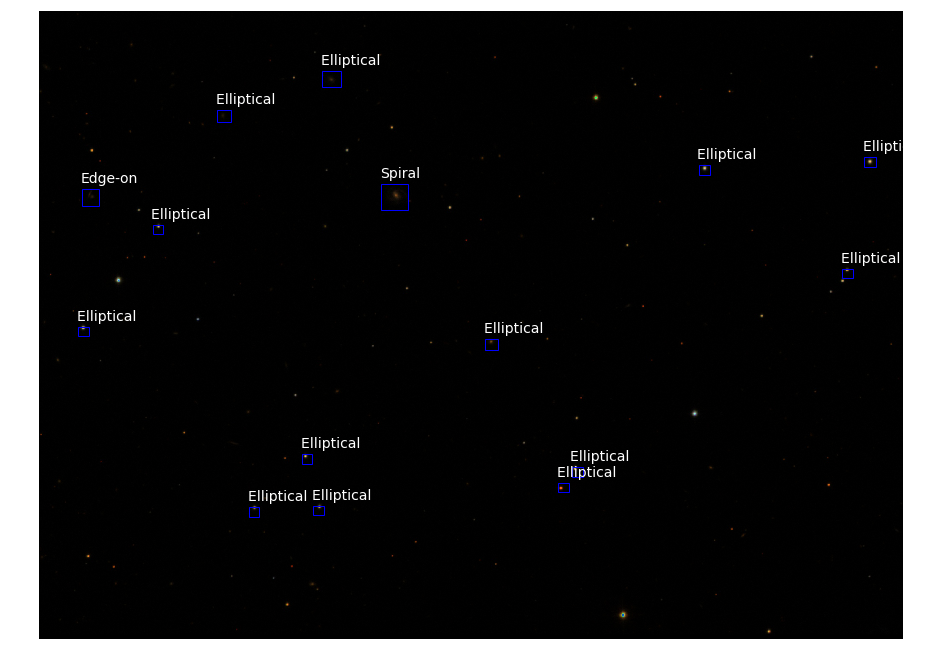

In [6]:
image =  filter_rgb(ii,ir,ig,stretch_type='lupton')


image.save(filename,'jpeg',quality=97)
t1=time.time()
pyyolo.init(darknet_path, datacfg, cfgfile, weightfile) #init and load network
print('Initialization time = %5.3f seconds'%(time.time()-t1))
t1=time.time() #actually loading the image take most of the time
outputs = pyyolo.test(filename, thresh, hier_thresh, 0,0) #load image and process
print('Load from file + Image processing time = %5.3f seconds'%(time.time()-t1))
for output in outputs:
        print(output)    
pyyolo.cleanup()

#plot image and detections
img = Image.open(filename)
fig,ax = plt.subplots(figsize=(12,9))
plt.axis('off')
plt.tight_layout(pad=0)
plt.imshow(img)
ax.set_aspect('equal')
for output in outputs:
        r=output['right']
        l=output['left']
        t=output['top']
        b=output['bottom']
        rect = patches.Rectangle((l-4,t-3),r-l+8,b-t+4,linewidth=1,edgecolor='b',facecolor='none')      
        ax.add_patch(rect)
        ax.annotate(output['class'],(l-7,t-18),color='w',fontsize=14)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.show()
plt.close()
os.remove(filename)
